In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.typing import ArrayLike


## Sampling 1D Gaussian via MCMC using Metropolois-Hastings 

We want to sample from the 1D Guassian distribution. 
To this end, we consider the _unnormalised_ (zero centered, i.e. $\mu = 0$) Guassian distribution 

$$\rho(x) = e^{- x^2 / (2 \sigma^2)}$$

Since normalisations are hard to get right using MCMC, it is better to compute moments.
For simplicity, we focus on 

$$ \langle x^2 \rangle = \frac{\int\ \rho(x) x^2 \ dx}{\int\ \rho(x)\ dx} = \mu^2 + \sigma^2 = \sigma^2$$

Idea:
1. use MCMC to sample a bunch of points $X = \{x_i\}_{i=1}^n$ from $\rho$ 
2. compute $\mathbb E[x^2] = \frac{1}{n} \sum_i x_i^2$

In [ ]:
def rho(x:ArrayLike,mu:float = 0,sigma:float = 1) -> ArrayLike:
    """
    Unnormalised Gaussian distribution

    :param x: x variable
    :type x: ArrayLike

    :param mu: mean
    :type mu: float

    :param sigma: standard deviation
    :type sigma: float

    :returns: Gaussian N(mu,sigma)
    :rtype: ArrayLike
    """
    return np.exp( - (x - mu)**2 / (2*sigma**2) )
    
def MCMC(xi:float,rho,N:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute transition probabilities T for a 1D Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x(i)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: Markov Chain sampled from rho and the acceptence rate
    :rtype: tuple[np.ndarray,float]
    """

    x = np.array([xi])
    accepted = 0
    sigma = np.array([])

    for _ in range(N):
        #PROPOSE NEXT STATE 
        xold = x[-1]
        xnew = xold + np.random.normal(loc=0,scale=1)
        
        A = min(1,rho(xnew)/rho(xold)) # acceptence probability 
        
        p = np.random.uniform(low=0,high=1) # uniform rnd number in [0,1]

        if p <= A:
            accepted += 1
            x = np.append(x,xnew)
        else:
            x = np.append(x,xold) 

        sigma = np.append(sigma,np.mean(x**2)) 

    samples = x[burnin::k] # first 'burnin' points are "burn in", then take only each kth point

    return (samples, accepted / N, sigma)

### Vanilla Gaussian

In [ ]:
# SAMPLE DISTRIBUTION rho
x, accepted, sigma = MCMC(xi=0,rho=rho,N=10_000,burnin=100,k=5)

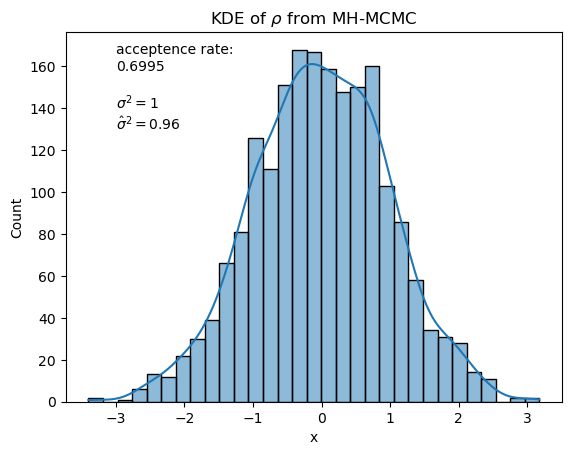

In [ ]:
# PLOT ESTIMATED PDF FROM SAMPLED DISTTRIBUTION
xs = pd.Series(x,name='x') 
sigma_hat = np.mean(x**2)

sns.histplot(data=xs,kde=True)
plt.text(-3,130,f'acceptence rate:\n{accepted}\n\n$\sigma^2 = 1$\n$\hat\sigma^2={sigma_hat:.2f}$')
plt.title(r'KDE of $\rho$ from MH-MCMC');


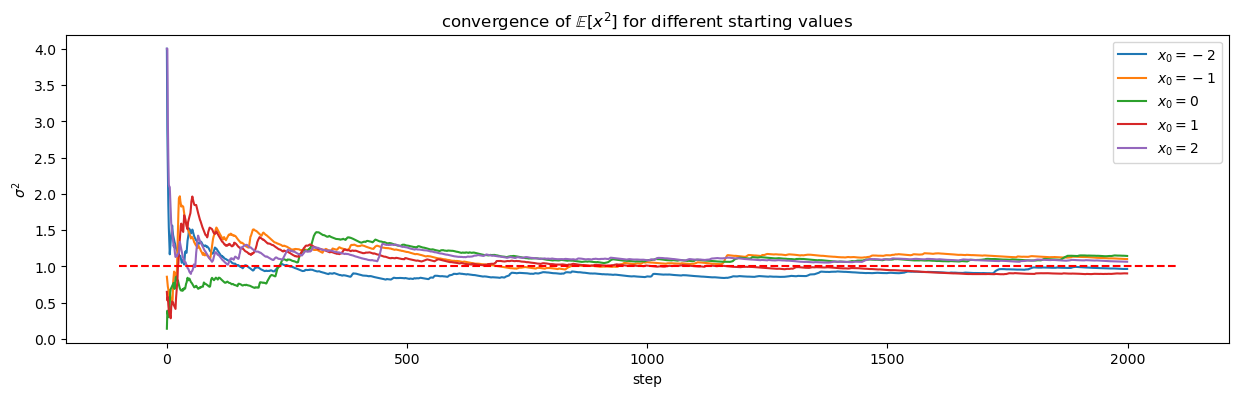

In [3]:
# CONVERGENCE OF E[x^2] FOR DIFFERENT STARTING VALUES xi
xs = []
sigmas = []
for i in range(5):
    xi = i - 2
    x, accepted, sigma = MCMC(xi=xi,rho=rho,N=2_000,burnin=100,k=5)
    xs.append(x)
    sigmas.append(sigma)


# PLOT 
fig, ax = plt.subplots(figsize=(15,4))

plt.ylabel(r'$\sigma^2$')
plt.xlabel('step')
plt.title(r'convergence of $\mathbb{E}[x^2]$ for different starting values');

for i in range(5):
    ax.plot(sigmas[i],label=f'$x_0 = {i - 2}$')

ax.hlines(y=1,xmin=-100,xmax=len(sigmas[0])+100,color='red',ls='--')
plt.legend()

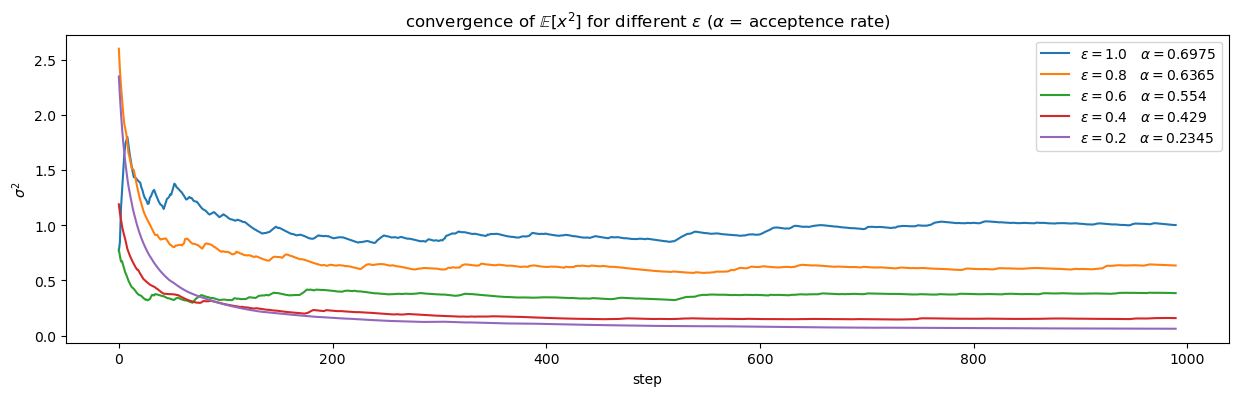

In [21]:
# CONVERGENCE OF E[x^2] FOR DIFFERENT sigma IN rho
xs = []
sigmas = []
alpha = [] # acceptence rates
for i in range(5):
    eps = 1 - 2*i/10
    x, accepted, sigma = MCMC(xi=xi,rho=lambda x: rho(x,eps),N=2_000,burnin=100,k=5)
    xs.append(x)
    sigmas.append(sigma)
    alpha.append(accepted)


# PLOT 
fig, ax = plt.subplots(figsize=(15,4))

plt.ylabel(r'$\sigma^2$')
plt.xlabel('step')
plt.title(r'convergence of $\mathbb{E}[x^2]$ for different $\epsilon$ ($\alpha$ = acceptence rate)');

for i in range(5):
    ax.plot(sigmas[i][10:1000],label=f'$\epsilon = {1 - 2*i/10:.1f} \quad \\alpha = {alpha[i]}$')

plt.legend(loc='upper right')

### Sum of Gaussians

In [ ]:
# DEFINE SUM OF 2 GAUSSIANS
f = lambda x: rho(x) + 0.5*rho(x,mu=4,sigma=1.5)

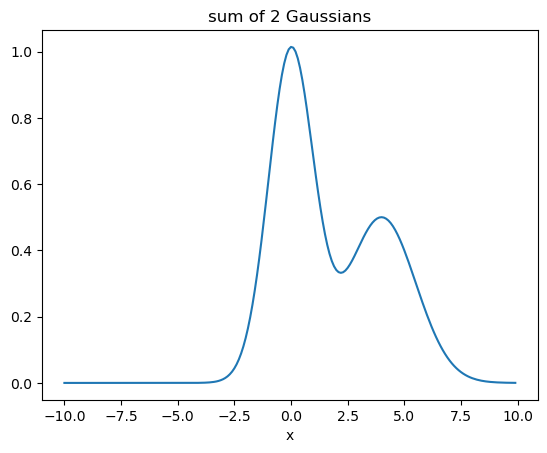

In [ ]:
# PLOT
x = np.arange(-10,10,0.1)
y = f(x)

plt.plot(x,y)
plt.title('sum of 2 Gaussians')
plt.xlabel('x')
plt.show()

In [ ]:
import scipy.integrate as integrate

In [ ]:
# SAMPLE DISTRIBUTION rho
x, accepted, sigma = MCMC(xi=0,rho=f,N=100_000,burnin=100,k=5)

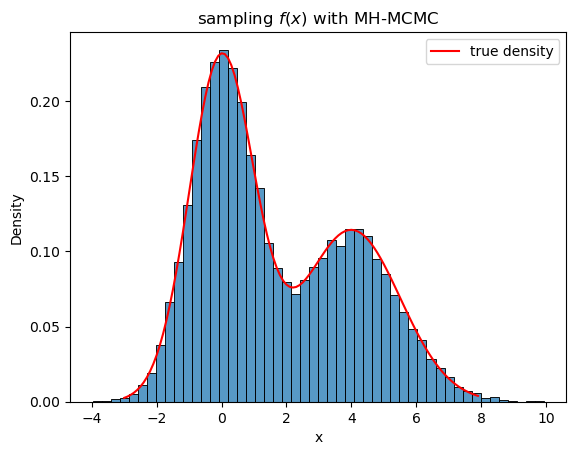

In [64]:

# PLOT ESTIMATED PDF FROM SAMPLED DISTTRIBUTION
xs = pd.Series(x,name='x') 
# sigma_hat = np.mean(x**2)
# PLOT
X = np.arange(-3,8,0.1)
y = f(X)

N = integrate.quad(f,-3,8)[0] # Normalisation for visual puproses 
y /= N


fig,ax = plt.subplots()

sns.histplot(data=xs,ax=ax,stat='density')
ax.plot(X,y,'r',label='true density')
ax.legend()

# plt.text(-3,130,f'acceptence rate:\n{accepted}\n\n$\sigma^2 = 1$\n$\hat\sigma^2={sigma_hat:.2f}$')
plt.title(r'sampling $f(x)$ with MH-MCMC');

## 2D Example: Sum of 2 Gaussians

In [2]:
def rho2D(x:np.ndarray,C:np.ndarray = np.eye(2) ,mu:np.ndarray = np.zeros(shape=(2,1))) -> ArrayLike:
    """
    Unnormalised 2D Gaussian distribution

    :param x: x variable
    :type x: ArrayLike

    :param mu: mean vector 
    :type mu: np.ndarray

    :param C: covariance matrix (positive semi-definite matrix)
    :type Sigma: np.ndarray

    :returns: Gaussian N(mu,sigma)
    :rtype: ArrayLike
    """

    X = x[:,:,np.newaxis] # cast x (-1,2) into (-1,2,1) => array of column vectors
    y = X - mu

    yy = ( 
        y.transpose(0,2,1) @ (C @ y) 
        ).flatten()
    
    return np.exp( - yy / 2 )

In [ ]:
C = np.array([[4,2],[2,3]])
mu1 = np.array([[-1],[-1]])
mu2 = np.array([[2],[2]])

x = np.linspace(-4,4,100)
y = np.linspace(-4,4,100)

xx, yy = np.meshgrid(x,y)

X = np.c_[xx.ravel(), yy.ravel()]

data = rho2D(x=X,mu=mu1) + rho2D(x=X,C=C,mu=mu2)


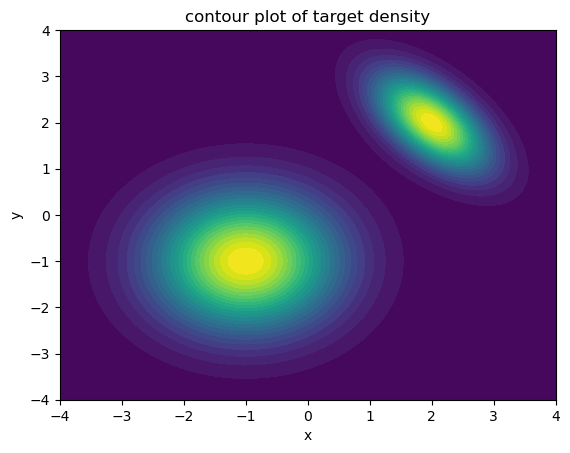

In [53]:
plt.contourf(xx,yy,data.reshape(xx.shape),levels=30)
plt.title('contour plot of target density')
plt.xlabel('x')
plt.ylabel('y');

In [21]:
def MCMC2D(xi:float,yi:float,rho,N:int,burnin:int,k:int) -> tuple[np.ndarray,float,np.ndarray]:
    """
    Metropolis–Hastings to compute transition probabilities T for a 1D Markov Chain Monte Carlo (MCMC)

    :param xi: initial state x(i)
    :type xi: float

    :param rho: (possibly unnormalised) probability mass function / probability distribution
    :type rho: function

    :param N: number of Monte Carlo steps
    :type N: int

    :param burnin: length of burn in phase
    :type burnin: int

    :param k: consider only each kth sample to mitigate correlations
    :type k: int

    :returns: samples , acceptence rate 
    :rtype: tuple[np.ndarray,float]
    """

    # INITIAL STATES ALONG x AND y AXIS
    x = np.array([xi])
    y = np.array([yi])

    accepted = 0
    # sigma = np.array([])

    for _ in range(N):
        #PROPOSE NEXT STATE 
        xold = x[-1]
        yold = y[-1]

        xnew = xold + np.random.normal(loc=0,scale=1)
        ynew = yold + np.random.normal(loc=0,scale=1)

        
        # ACCEPTENCE PROBABILITIES
        vold = np.array([xold,yold]).reshape(-1,2)  # old point
        vnewx = np.array([xnew,yold]).reshape(-1,2) # new x 
        vnewy = np.array([xold,ynew]).reshape(-1,2) # new y

        Ax = min(1 , rho(vnewx) / rho(vold) )
        Ay = min(1 , rho(vnewy) / rho(vold) ) 
        
        # CHECK IF ACCEPTED
        px = np.random.uniform(low=0,high=1) 
        py = np.random.uniform(low=0,high=1) 

        if  px <= Ax:
            accepted += 1
            x = np.append(x,xnew)
        else:
            x = np.append(x,xold) 

        if  py <= Ay:
            accepted += 1
            y = np.append(y,ynew)
        else:
            y = np.append(y,yold) 

        # sigma = np.append(sigma,np.mean(x**2)) 

    samples = np.array(list(zip(x[burnin::k],y[burnin::k]))) # first 'burnin' points are "burn in", then take only each kth point

    return (samples, accepted / (2*N))

In [12]:
C = np.array([[4,2],[2,3]])
mu1 = np.array([[-1],[-1]])
mu2 = np.array([[2],[2]])

x = np.linspace(-4,4,10)
y = np.linspace(-4,4,10)

xx, yy = np.meshgrid(x,y)

X = np.c_[xx.ravel(), yy.ravel()]

f = lambda x: rho2D(x=x,mu=mu1) + rho2D(x=x,C=C,mu=mu2)

In [ ]:
xi = 0
yi = 0

samples, alpha = MCMC2D(xi=0,yi=0,rho=f,N=100_000,burnin=100,k=5)

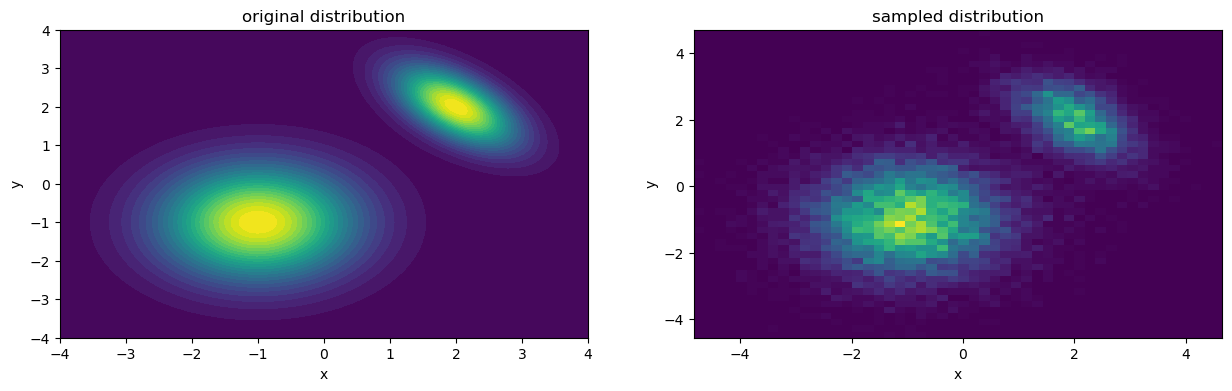

In [75]:
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(15,4))


ax[0].contourf(xx,yy,data.reshape(xx.shape),levels=30)
ax[0].set_title('original distribution')
ax[1].hist2d(x = samples[:,0], y = samples[:,1],bins=50)
ax[1].set_title('sampled distribution')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[1].set_xlabel('x')
ax[1].set_ylabel('y');

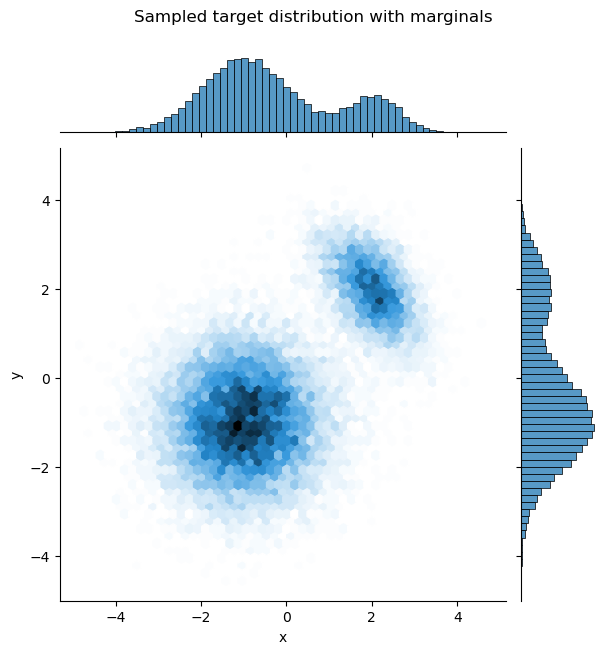

In [73]:
sns.jointplot(x = samples[:,0], y = samples[:,1],kind='hex')
plt.suptitle('Sampled target distribution with marginals',y=1.05)
plt.xlabel('x')
plt.ylabel('y');